In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pathlib
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
tf.autograph.set_verbosity(0)

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import gc
gc.collect()

70

# 加载数据

In [5]:
data_root = pathlib.Path('/mnt/data_set/criteo_ctr')
data = pd.read_csv(data_root/'sample.csv', delimiter='\t', header=None, nrows=1e5)

In [6]:
data.shape

(100000, 40)

In [7]:
label = ['label']
dense_features = ['I' + str(i) for i in range(1, 14)]
sparse_features = ['C' + str(i) for i in range(1, 27)]
name_list = label + dense_features + sparse_features
data.columns = name_list
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


# 数据预处理

## 定义特征组

In [8]:
dense_feats = [f for f in name_list if f[0] == "I"]
sparse_feats = [f for f in name_list if f[0] == "C"]
print('dense_feats: :%s' %dense_feats)
print('sparse_feats: %s'% sparse_feats)

dense_feats: :['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
sparse_feats: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


## 处理dense特征

In [9]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [10]:
data_dense = process_dense_feats(data, dense_feats)

## 处理sparse特征

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [13]:
data_sparse = process_sparse_feats(data, sparse_feats)

In [14]:
total_data = pd.concat([data_dense, data_sparse], axis=1)
total_data['label'] = data['label']
total_data

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,label
0,0.693147,0.693147,1.791759,0.000000,7.232010,1.609438,2.772589,1.098612,5.204007,0.693147,...,2422,150,3,1163,0,2,9570,41,5604,0
1,1.098612,0.000000,3.806662,0.693147,4.634729,2.197225,1.098612,1.098612,1.609438,0.693147,...,1727,150,1,14512,0,2,3233,41,4215,0
2,1.098612,0.000000,0.693147,2.708050,6.643790,4.499810,1.609438,1.098612,5.505332,0.693147,...,510,0,0,34644,6,2,2818,0,0,0
3,0.000000,6.795706,0.000000,0.000000,8.387768,0.000000,0.000000,0.000000,0.000000,0.000000,...,1170,0,0,15997,0,2,6971,0,0,0
4,1.386294,-1.000000,0.000000,0.000000,1.098612,0.000000,1.386294,0.000000,0.000000,0.693147,...,390,0,0,5101,0,1,8663,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.693147,4.110874,3.637586,0.000000,0.693147,0.000000,1.609438,0.000000,3.178054,0.693147,...,560,150,3,5553,0,1,3818,12,4183,0
99996,0.000000,0.000000,2.564949,0.000000,12.061752,0.000000,0.000000,1.386294,2.397895,0.000000,...,1727,150,3,14512,0,1,3233,43,4215,1
99997,2.397895,1.098612,0.693147,3.295837,6.180017,4.110874,2.397895,2.484907,4.110874,0.693147,...,1648,150,2,12138,0,1,2271,2,8780,0
99998,0.000000,5.968708,3.784190,1.609438,12.752360,0.000000,0.000000,1.609438,1.609438,0.000000,...,302,0,0,32886,0,1,6918,0,0,0


In [15]:
total_data.label.value_counts(normalize=True)

0    0.77337
1    0.22663
Name: label, dtype: float64

In [16]:
y = data['label']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
y.shape

(100000,)

In [19]:
train_dense_inputs, test_dense_inputs, train_sparse_inputs, test_sparse_inputs, train_y, test_y = train_test_split(
    data_dense.values, data_sparse.values, y.values, test_size=0.3, shuffle=False)

In [20]:
train_dense_inputs.shape, train_sparse_inputs.shape, train_y.shape

((70000, 13), (70000, 26), (70000,))

In [21]:
test_dense_inputs.shape, test_sparse_inputs.shape, test_y.shape

((30000, 13), (30000, 26), (30000,))

In [22]:
category_dim = data_sparse.nunique().values
print(category_dim)

[  541   497 43870 25184   145    12  7623   257     3 10997  3799 41312
  2796    26  5238 34617    10  2548  1303     4 38618    11    14 12335
    51  9527]


# 模型构建与训练

## 一阶特征

### dense特征

In [23]:
class LinearLayer(layers.Layer):
    def __init__(self, category_dim=[]):
        super(LinearLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(1)
        self.embeddings = []
        for size in category_dim:
            em = layers.Embedding(size+1, 1)
            self.embeddings.append(em)
    
    def call(self, inputs):
        if len(self.embeddings) > 0:
            dense_inputs, sparse_inputs = inputs
            embedding_outputs = []
            for i in range(sparse_inputs.shape[1]):
                x = sparse_inputs[:, i]
                x = self.embeddings[i](x)
                embedding_outputs.append(x)
            
            x = tf.concat(embedding_outputs, axis=1)
            x = tf.concat([dense_inputs, x], axis=1)
        else:
            x = inputs
        x = self.dense(x)
        return x


In [24]:
class EmbeddingLayer(layers.Layer):
    def __init__(self, category_dim, embedding_dim=8):
        super(EmbeddingLayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.embeddings = []
        for size in category_dim:
            em = layers.Embedding(size+1, embedding_dim)
            self.embeddings.append(em)    

    def call(self, sparse_inputs):
        embedding_outputs = []
        for i in range(sparse_inputs.shape[1]):
            x = sparse_inputs[:, i]
            x = self.embeddings[i](x)
            embedding_outputs.append(x)

        x = tf.stack(embedding_outputs, axis=1)  ## [batch, feat, embedding_dim]
        return x

FM 用于二阶特征交叉
$$\sum_{i=1}^n\sum_{j=i+1}^n \langle v_i, v_j \rangle x_i x_j=\frac{1}{2} \sum_{f=1}^k[(\sum_{i=1}^n V_{if})^2 - \sum_{i=1}^n V_{if}^2]$$

In [25]:
class FMLayer(layers.Layer):
    def __init__(self):
        super(FMLayer, self).__init__()
        # 只考虑sparse特征的二阶交叉
        
    def call(self, inputs):
        ## inputs is EmbeddingLayer's output
        # 和的平方
        x = inputs
        s = tf.reduce_sum(x, axis=1)
        sum_square = tf.multiply(s, s)
        # 平方的和
        square_sum = tf.reduce_sum(tf.multiply(x, x), axis=1)
        # 相减再求和除以2
        x = tf.reduce_sum(sum_square - square_sum, axis=1, keepdims=True) / 2
        return x

In [26]:
class DNN(layers.Layer):
    def __init__(self, kernels_size=[]):
        super(DNN, self).__init__()
        assert len(kernels_size) > 0
        self.denses = []
        self.dropouts = []
        for size in kernels_size:
            self.denses.append(layers.Dense(size, activation='relu'))
        for i in range(len(kernels_size)-1):
            self.dropouts.append(layers.Dropout(0.3))
        self.dropouts.append(layers.Dropout(0.1))
        self.output_layer = layers.Dense(1)
    
    def call(self, inputs):
        dense_inputs, embedding_inputs = inputs  ## [batch, dense_feats], [batch, feat, embedding_dim]
        x = layers.Flatten()(embedding_inputs)
        x = tf.concat([dense_inputs, x], axis=1)
        for dense, dropout in zip(self.denses, self.dropouts):
            x = dense(x)
            x = dropout(x)
        x = self.output_layer(x)
        return x

In [27]:
class DeepFM(tf.keras.Model):
    def __init__(self, category_dim, embedding_dim=8, dnn_layers=[8]):
        super(DeepFM, self).__init__()
        self.category_dim = category_dim
        self.linear_layer = LinearLayer(category_dim)
        self.em_layer = EmbeddingLayer(category_dim, embedding_dim)
        self.fm_layer = FMLayer()
        self.dnn_layer = DNN(kernels_size=dnn_layers)
        
    def call(self, inputs):
        dense_inputs, sparse_inputs = inputs
#         print('dense_inputs shape: ', dense_inputs.shape)
#         print('sparse_inputs shape: ', sparse_inputs.shape)
        linear_output = self.linear_layer([dense_inputs, sparse_inputs])
        em_output = self.em_layer(sparse_inputs)
        fm_output = self.fm_layer(em_output)
        dnn_output = self.dnn_layer([dense_inputs, em_output])
        out = layers.Add()([linear_output, fm_output, dnn_output])
        out = layers.Activation('sigmoid')(out)
        return out

In [28]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

In [29]:
import shutil
log_dir = './logs'
shutil.rmtree(log_dir, ignore_errors=True)

In [30]:
tbCallBack = TensorBoard(log_dir=log_dir,  # log 目录
                 histogram_freq=0, 
                 write_graph=True,
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

## 仅使用Adam

In [31]:
model = DeepFM(category_dim, embedding_dim=2, dnn_layers=[16, 8])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.fit([train_dense_inputs, train_sparse_inputs], train_y, epochs=5, batch_size=64, 
         validation_data=([test_dense_inputs, test_sparse_inputs], test_y))

Train on 70000 samples, validate on 30000 samples
Epoch 1/5
70000/70000 [==============================] - 15s 211us/sample - loss: 0.5044 - auc: 0.6960 - val_loss: 0.4522 - val_auc: 0.7699
Epoch 2/5
70000/70000 [==============================] - 10s 142us/sample - loss: 0.3831 - auc: 0.8436 - val_loss: 0.4657 - val_auc: 0.7588
Epoch 3/5
70000/70000 [==============================] - 10s 144us/sample - loss: 0.2879 - auc: 0.9173 - val_loss: 0.5188 - val_auc: 0.7323
Epoch 4/5
70000/70000 [==============================] - 10s 144us/sample - loss: 0.2278 - auc: 0.9486 - val_loss: 0.5650 - val_auc: 0.7180
Epoch 5/5
70000/70000 [==============================] - 10s 147us/sample - loss: 0.1967 - auc: 0.9624 - val_loss: 0.6081 - val_auc: 0.7117


## 仅使用FTRL

In [32]:
model = DeepFM(category_dim, embedding_dim=2, dnn_layers=[16, 8])
model.compile(optimizer='ftrl', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.fit([train_dense_inputs, train_sparse_inputs], train_y, epochs=5, batch_size=64, 
         validation_data=([test_dense_inputs, test_sparse_inputs], test_y))

Train on 70000 samples, validate on 30000 samples
Epoch 1/5
70000/70000 [==============================] - 11s 163us/sample - loss: 0.5238 - auc_1: 0.6121 - val_loss: 0.5246 - val_auc_1: 0.6328
Epoch 2/5
70000/70000 [==============================] - 8s 116us/sample - loss: 0.5156 - auc_1: 0.6375 - val_loss: 0.5191 - val_auc_1: 0.6491
Epoch 3/5
70000/70000 [==============================] - 8s 120us/sample - loss: 0.5115 - auc_1: 0.6497 - val_loss: 0.5156 - val_auc_1: 0.6584
Epoch 4/5
70000/70000 [==============================] - 9s 123us/sample - loss: 0.5086 - auc_1: 0.6573 - val_loss: 0.5130 - val_auc_1: 0.6649
Epoch 5/5
70000/70000 [==============================] - 9s 122us/sample - loss: 0.5065 - auc_1: 0.6627 - val_loss: 0.5110 - val_auc_1: 0.6696


## wide部分使用ftrl，deep部分使用adam


In [33]:
loss = tf.keras.losses.BinaryCrossentropy(name='bce')
adam = tf.keras.optimizers.Adam()  ## use name or class
ftrl = tf.keras.optimizers.Ftrl()

In [34]:
train_auc = tf.keras.metrics.AUC(name='train_auc')
test_auc = tf.keras.metrics.AUC(name='test_auc')

train_bce = tf.keras.metrics.BinaryCrossentropy(name='train_bce')
test_bce = tf.keras.metrics.BinaryCrossentropy(name='test_bce')

In [35]:
model2 = DeepFM(category_dim, embedding_dim=4, dnn_layers=[32, 16])

In [36]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        pred = model2(x, training=True)
        l = loss(y, pred)
    grads = tape.gradient(l, model2.trainable_variables)
    
    linear_grads, linear_variables = [], []
    dnn_grads, dnn_variables = [], []

    for grad, variable in zip(grads, model2.trainable_variables):
        if 'linear_layer' in variable.name:
            linear_grads.append(grad)
            linear_variables.append(variable)
        else:
            dnn_grads.append(grad)
            dnn_variables.append(variable)
    
    ftrl.apply_gradients(zip(linear_grads, linear_variables))
    adam.apply_gradients(zip(dnn_grads, dnn_variables))
    
    pred = tf.squeeze(pred, axis=1)
    train_auc(y, pred)
    train_bce(y, pred)
    
@tf.function
def test_step(x, y):
    pred = model2(x, training=False)
    t_l = loss(y, pred)
    pred = tf.squeeze(pred, axis=1)
    test_auc(y, pred)
    test_bce(y, pred)

In [37]:
EPOCHS = 5
batch = 64
template = 'Epoch {}, Loss: {}, AUC: {}, Test Loss: {}, Test AUC: {}'

for epoch in range(EPOCHS):
    train_auc.reset_states()
    test_auc.reset_states()
    
    train_bce.reset_states()
    test_bce.reset_states()
    
    for i in range(0, len(train_y)-batch+1, batch):
        d_x, s_x, b_y = train_dense_inputs[i:i+batch], train_sparse_inputs[i:i+batch], train_y[i:i+batch]
        train_step([d_x, s_x], b_y)
    
    for i in range(0, len(test_y)-batch+1, batch):
        d_x, s_x, b_y = test_dense_inputs[i:i+batch], test_sparse_inputs[i:i+batch], test_y[i:i+batch]
        test_step([d_x, s_x], b_y)

    print(template.format(epoch+1, train_bce.result(), train_auc.result(), test_bce.result(), test_auc.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.5178151726722717, AUC: 0.6876399517059326, Test Loss: 0.45145383477211, Test AUC: 0.7728200554847717
Epoch 2, Loss: 0.3871661424636841, AUC: 0.8380054831504822, Test Loss: 0.4829258918762207, Test AUC: 0.7522549033164978
Epoch 3, Loss: 0.27296504378318787, AUC: 0.9242410063743591, Test Loss: 0.5672544240951538, Test AUC: 0.7185109853744507
Epoch 4, Loss: 0.20483006536960602, AUC: 0.9582580924034119, Test Loss: 0.6449427604675293, Test AUC: 0.7066455483436584
Epoch 5, Loss: 0.16956418752

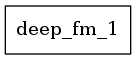

In [38]:
plot_model(model, 'deep_fm.png')

In [39]:
model.summary()

Model: "deep_fm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_layer_1 (LinearLayer) multiple                  241404    
_________________________________________________________________
embedding_layer_1 (Embedding multiple                  482728    
_________________________________________________________________
fm_layer_1 (FMLayer)         multiple                  0         
_________________________________________________________________
dnn_1 (DNN)                  multiple                  1201      
Total params: 725,333
Trainable params: 725,333
Non-trainable params: 0
_________________________________________________________________


In [40]:
!tensorboard --logdir ./logs

/bin/sh: 1: tensorboard: not found
